In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna.integration.lightgbm as lgbo
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
import shap
import seaborn as sns

DIR_PATH = '/Users/sasanoshouta/Desktop/DIVE_INTO_CODE/kaggle/MDataFiles_Stage2'

# load JS visualization code to notebook
shap.initjs()

In [188]:
train = pd.read_csv(DIR_PATH+'/final_regular_result.csv')
test = pd.read_csv(DIR_PATH+'/stage1_test.csv')

y = train["result"]
s = train["Season"]
X = train.drop(['Season','TeamID1','TeamID2','result'], axis=1)
X_test = test.drop(['ID', 'Season','TeamID1','TeamID2'], axis=1)

X = pd.get_dummies(X)
X_test = pd.get_dummies(X_test)

Columns (41,44) have mixed types.Specify dtype option on import or set low_memory=False.


In [189]:
x_column = X.columns
test_column = X_test.columns
no_train_feat = []
no_test_feat = []

for i in x_column:
    if i not in test_column:
        no_train_feat.append(i)
        
X.drop(no_train_feat, axis=1, inplace=True)

x_column = X.columns
test_column = X_test.columns
for i in test_column:
    if i not in x_column:
        no_test_feat.append(i)
X_test.drop(no_test_feat, axis=1, inplace=True)

In [190]:
X

,Points_Per_Possession_1,NRTG_1,PACE_1,TS%_1,AdjEM_1,eFG%_1,TOV%_1,OREB%_1,DREB%_1,FTR_1,...,RankMax_2,RankMin_2,RankStd_2,RankMean_2,RankTrans_50_51_to_127_128_2,RankTrans_15_16_to_127_128_2,seed_1,quality_1,seed_2,quality_2
0,0.888400,6.413600,1.608088,0.526925,-0.654677,0.496626,0.188138,0.328046,0.689116,0.320432,...,339.0,298.0,11.483364,321.352941,0.062678,0.091168,-1.0,-1.000000,-1.0,-1.0
1,0.791964,-17.094305,1.600133,0.502975,0.287299,0.466930,0.241614,0.228475,0.700752,0.380272,...,116.0,95.0,6.456301,107.058824,-0.056980,-0.019943,-1.0,-1.000000,-1.0,-1.0
2,0.926717,3.369313,1.564742,0.556632,0.187854,0.505980,0.194009,0.297806,0.687378,0.459749,...,261.0,166.0,30.021928,229.235294,0.128205,0.182336,-1.0,-1.000000,-1.0,-1.0
3,0.826042,-5.631398,1.536839,0.501806,-0.502381,0.450531,0.215796,0.410475,0.707765,0.498188,...,61.0,36.0,7.406774,52.117647,-0.005698,0.025641,-1.0,-1.000000,-1.0,-1.0
4,0.992801,26.530881,1.656294,0.578984,0.133540,0.532952,0.169081,0.339444,0.781373,0.478994,...,289.0,207.0,21.371538,240.352941,-0.065527,0.011396,2.0,691.305669,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144671,0.994681,9.775507,1.826444,0.574367,0.568291,0.532948,0.153278,0.301364,0.677652,0.347753,...,68.0,6.0,22.089644,25.666667,-0.173185,-1.000000,-1.0,-1.000000,-1.0,-1.0
144672,0.968277,27.172667,1.658500,0.552980,1.250096,0.510378,0.152958,0.389552,0.761093,0.313219,...,121.0,50.0,20.113488,93.133333,0.001582,-1.000000,-1.0,-1.000000,-1.0,-1.0
144673,0.860595,-4.501280,1.797261,0.518065,-1.255999,0.484938,0.190379,0.260255,0.765605,0.337765,...,14.0,5.0,2.693908,9.600000,0.000888,-1.000000,-1.0,-1.000000,-1.0,-1.0
144674,1.010755,9.237440,1.709367,0.579279,0.709214,0.532412,0.145291,0.273956,0.753479,0.379823,...,23.0,3.0,5.942582,7.200000,-0.016565,-1.000000,-1.0,-1.000000,-1.0,-1.0


In [191]:
X_test

,Points_Per_Possession_1,NRTG_1,PACE_1,TS%_1,AdjEM_1,eFG%_1,TOV%_1,OREB%_1,DREB%_1,FTR_1,...,RankMax_2,RankMin_2,RankStd_2,RankMean_2,RankTrans_50_51_to_127_128_2,RankTrans_15_16_to_127_128_2,seed_1,quality_1,seed_2,quality_2
0,0.939144,19.965877,1.792696,0.560750,-0.405907,0.528451,0.187355,0.292734,0.750584,0.349150,...,68,6,22.089644,25.666667,-0.173185,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.939144,19.965877,1.792696,0.560750,-0.405907,0.528451,0.187355,0.292734,0.750584,0.349150,...,263,139,41.363315,212.066667,0.177100,-1.0,-1.0,-1.0,-1.0,-1.0
2,0.939144,19.965877,1.792696,0.560750,-0.405907,0.528451,0.187355,0.292734,0.750584,0.349150,...,77,6,18.609521,18.200000,-0.041452,-1.0,-1.0,-1.0,-1.0,-1.0
3,0.939144,19.965877,1.792696,0.560750,-0.405907,0.528451,0.187355,0.292734,0.750584,0.349150,...,4,1,0.833809,1.866667,0.000161,-1.0,-1.0,-1.0,-1.0,-1.0
4,0.939144,19.965877,1.792696,0.560750,-0.405907,0.528451,0.187355,0.292734,0.750584,0.349150,...,68,31,11.909580,52.866667,-0.044955,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4551,0.948061,17.402617,1.824667,0.566447,0.718406,0.531264,0.185688,0.328939,0.816961,0.365747,...,48,19,9.255629,34.333333,0.002745,-1.0,-1.0,-1.0,-1.0,-1.0
4552,0.948294,8.072436,1.676897,0.535697,-0.254226,0.496072,0.128341,0.206791,0.776710,0.274942,...,48,19,9.255629,34.333333,0.002745,-1.0,-1.0,-1.0,-1.0,-1.0
4553,0.948061,17.402617,1.824667,0.566447,0.718406,0.531264,0.185688,0.328939,0.816961,0.365747,...,104,29,18.531055,85.400000,-0.069899,-1.0,-1.0,-1.0,-1.0,-1.0
4554,0.948294,8.072436,1.676897,0.535697,-0.254226,0.496072,0.128341,0.206791,0.776710,0.274942,...,104,29,18.531055,85.400000,-0.069899,-1.0,-1.0,-1.0,-1.0,-1.0


パラメータチューニング：https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f<br>
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html<br>
https://hackerdemy.com/2020/09/15/lightgbm-classification/<br>
https://zenn.dev/mosamosa/articles/07d0076c9292136a3639<br>

In [192]:
# パラメータチューニング：https://qiita.com/R1ck29/items/50ba7fa5afa49e334a8f
# -------------------現状のベストパラメータ保管場所------------------
# 候補1 : cv mean : 0.4949, 使用特徴量：全て(2015~2021), kfold=6
best_lgb_params1 = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 128,
              'feature_fraction': 0.6,
              'bagging_fraction': 0.6,
              'bagging_freq': 5,
              'learning_rate': 0.05,
              'max_bin':600,
              'seed':2021,
                'num_iterations':10000
}

# 候補3: cv mean:0.4925, kfold=6
best_lgb_params3 = {'objective': 'binary',
              'metric': 'binary_logloss',
              'boosting': 'gbdt',
              'num_leaves': 1000,
              'max_depth': 15,
              'feature_fraction': 0.3,
              'bagging_fraction': 0.6,
              'bagging_freq': 5,
              'learning_rate': 0.01,
              'max_bin':125,
              'seed':2021,
              'min_data_in_leaf':13,
              'lambda_l1': 2.5,
              'extra_trees': True,
              'num_iterations':10000
}

# -------------------色々パラメータで遊んで精度見てみる場所------------------
# lgb_params = {'objective': 'binary',
#               'metric': 'binary_logloss',
#               'boosting': 'gbdt',
#               'num_leaves': 23,
#               'max_depth' : 5,
#               'max_bin' : 600,
#               'min_sum_hessian_in_leaf' : 1e-5,
#               'feature_fraction': 0.8,
#               'bagging_fraction': 0.6,
#               'bagging_freq': 5,
#               'learning_rate': 0.05,
#               'num_iterations' : 5000,
#               'random_state' : 42
#              }

# cv mean:0.492→特徴量全乗せ、2019までののシーズン 　0.4813→全乗せ、全てのシーズン
# cv mean:→特徴量全盛、2015~2021使用
# lgb_params = {'objective': 'binary',
#               'metric': 'binary_logloss',
#               'boosting': 'gbdt',
#               'num_leaves': 1000,
#               'max_depth': 15,
#               'feature_fraction': 0.1,
#               'bagging_fraction': 0.6,
#               'bagging_freq': 5,
#               'learning_rate': 0.01,
#               'max_bin':125,
#               'seed':2021,
#               'min_data_in_leaf':13,
#               'lambda_l1': 2.5,
#               'extra_trees': True,
#               'num_iterations':10000
# }

lgb_params = {'objective': 'regression',
              'metric': 'mae',
              'boosting': 'dart',
              'num_leaves': 32,
              'min_data_in_leaf': 40,
              'feature_fraction': 0.9,
              'bagging_fraction': 0.8,
              'bagging_freq': 3,
              'learning_rate': 0.02,
              'num_iterations' : 300,
              'max_depth':5
             }

def model_training(X, y, cv, groups, params, metric, early_stopping=10, \
    plt_iter=True, X_test=[], cat_features=[]):

    feature_importance = pd.DataFrame()
    val_scores=[]
    train_evals=[]
    valid_evals=[]

    if len(X_test) > 0:
        test_pred=np.zeros(len(X_test))

    for idx, (train_index, val_index) in enumerate(cv.split(X, y, groups)):

        print("###### fold %d ######" % (idx+1))
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
    
        model = lgb.LGBMClassifier(**params)

        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=early_stopping,
                  verbose=20
                  #categorical_feature=list(cate_ft_lst),
                  )

        val_scores.append(model.best_score_['valid_1'][metric])
        train_evals.append(model.evals_result_['training'][metric])
        valid_evals.append(model.evals_result_['valid_1'][metric])
        

        if len(X_test) > 0:
            test_pred = test_pred + model.predict_proba(X_test)[:,1]

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X_train.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = idx+1
        feature_importance = pd.concat([feature_importance, fold_importance]
                                       , axis=0)
    
    
    if plt_iter:
        
        fig, axs = plt.subplots(2, 2, figsize=(9,20))
        
        for i, ax in enumerate(axs.flatten()):
            ax.plot(train_evals[i], label='training')
            ax.plot(valid_evals[i], label='validation')
            ax.set(xlabel='interations', ylabel=f'{metric}')
            ax.set_title(f'fold {i+1}', fontsize=12)
            ax.legend(loc='upper right', prop={'size': 9})
        fig.tight_layout()
        plt.show()
    
    print('### CV scores by fold ###')
    for i in range(cv.get_n_splits(X)):
        print(f'fold {i+1}: {val_scores[i]:.4f}')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'\
          .format(np.mean(val_scores), np.std(val_scores)))
    
    feature_importance = feature_importance[["feature", "importance"]]\
                         .groupby("feature").mean().sort_values(
                         by="importance", ascending=False)
    feature_importance.reset_index(inplace=True)

    if len(X_test) > 0:
        test_pred = test_pred / cv.get_n_splits(X)
        return feature_importance, test_pred
    else:
        return feature_importance

###### fold 1 ######


Found `num_iterations` in params. Will use it instead of argument
Early stopping is not available in dart mode


[20]	training's l1: 0.458551	valid_1's l1: 0.459418
[40]	training's l1: 0.435832	valid_1's l1: 0.43736
[60]	training's l1: 0.429618	valid_1's l1: 0.431315
[80]	training's l1: 0.421656	valid_1's l1: 0.423315
[100]	training's l1: 0.419892	valid_1's l1: 0.421544
[120]	training's l1: 0.415917	valid_1's l1: 0.417846
[140]	training's l1: 0.410351	valid_1's l1: 0.412217
[160]	training's l1: 0.412763	valid_1's l1: 0.414517
[180]	training's l1: 0.401913	valid_1's l1: 0.403996
[200]	training's l1: 0.394574	valid_1's l1: 0.396754
[220]	training's l1: 0.390897	valid_1's l1: 0.393177
[240]	training's l1: 0.384752	valid_1's l1: 0.387324
[260]	training's l1: 0.381199	valid_1's l1: 0.383746
[280]	training's l1: 0.376926	valid_1's l1: 0.379716
[300]	training's l1: 0.374403	valid_1's l1: 0.377318
###### fold 2 ######


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


Early stopping is not available in dart mode


[20]	training's l1: 0.458152	valid_1's l1: 0.459409
[40]	training's l1: 0.435181	valid_1's l1: 0.437146
[60]	training's l1: 0.428867	valid_1's l1: 0.431106
[80]	training's l1: 0.420935	valid_1's l1: 0.423465
[100]	training's l1: 0.419198	valid_1's l1: 0.421819
[120]	training's l1: 0.415254	valid_1's l1: 0.418117
[140]	training's l1: 0.409665	valid_1's l1: 0.412735
[160]	training's l1: 0.412134	valid_1's l1: 0.415167
[180]	training's l1: 0.40094	valid_1's l1: 0.404491
[200]	training's l1: 0.39356	valid_1's l1: 0.39746
[220]	training's l1: 0.389994	valid_1's l1: 0.394081
[240]	training's l1: 0.383731	valid_1's l1: 0.388321
[260]	training's l1: 0.380391	valid_1's l1: 0.385244
[280]	training's l1: 0.376193	valid_1's l1: 0.381365
[300]	training's l1: 0.373757	valid_1's l1: 0.379213
###### fold 3 ######


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


Early stopping is not available in dart mode


[20]	training's l1: 0.458131	valid_1's l1: 0.460049
[40]	training's l1: 0.435248	valid_1's l1: 0.438375
[60]	training's l1: 0.429016	valid_1's l1: 0.43258
[80]	training's l1: 0.421095	valid_1's l1: 0.42519
[100]	training's l1: 0.419447	valid_1's l1: 0.423604
[120]	training's l1: 0.415379	valid_1's l1: 0.419928
[140]	training's l1: 0.409568	valid_1's l1: 0.414248
[160]	training's l1: 0.412057	valid_1's l1: 0.416608
[180]	training's l1: 0.400969	valid_1's l1: 0.406157
[200]	training's l1: 0.393599	valid_1's l1: 0.39909
[220]	training's l1: 0.389836	valid_1's l1: 0.395533
[240]	training's l1: 0.383427	valid_1's l1: 0.389423
[260]	training's l1: 0.380054	valid_1's l1: 0.386238
[280]	training's l1: 0.375879	valid_1's l1: 0.382546
[300]	training's l1: 0.373334	valid_1's l1: 0.380211
###### fold 4 ######


Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


Early stopping is not available in dart mode


[20]	training's l1: 0.458563	valid_1's l1: 0.458419
[40]	training's l1: 0.435595	valid_1's l1: 0.435318
[60]	training's l1: 0.429477	valid_1's l1: 0.429149
[80]	training's l1: 0.421377	valid_1's l1: 0.420994
[100]	training's l1: 0.419787	valid_1's l1: 0.419401
[120]	training's l1: 0.41588	valid_1's l1: 0.415312
[140]	training's l1: 0.410271	valid_1's l1: 0.409648
[160]	training's l1: 0.412883	valid_1's l1: 0.412238
[180]	training's l1: 0.401819	valid_1's l1: 0.400956
[200]	training's l1: 0.394552	valid_1's l1: 0.393612
[220]	training's l1: 0.390924	valid_1's l1: 0.389864
[240]	training's l1: 0.384817	valid_1's l1: 0.383517
[260]	training's l1: 0.381329	valid_1's l1: 0.379911
[280]	training's l1: 0.377301	valid_1's l1: 0.375666
[300]	training's l1: 0.37479	valid_1's l1: 0.373098


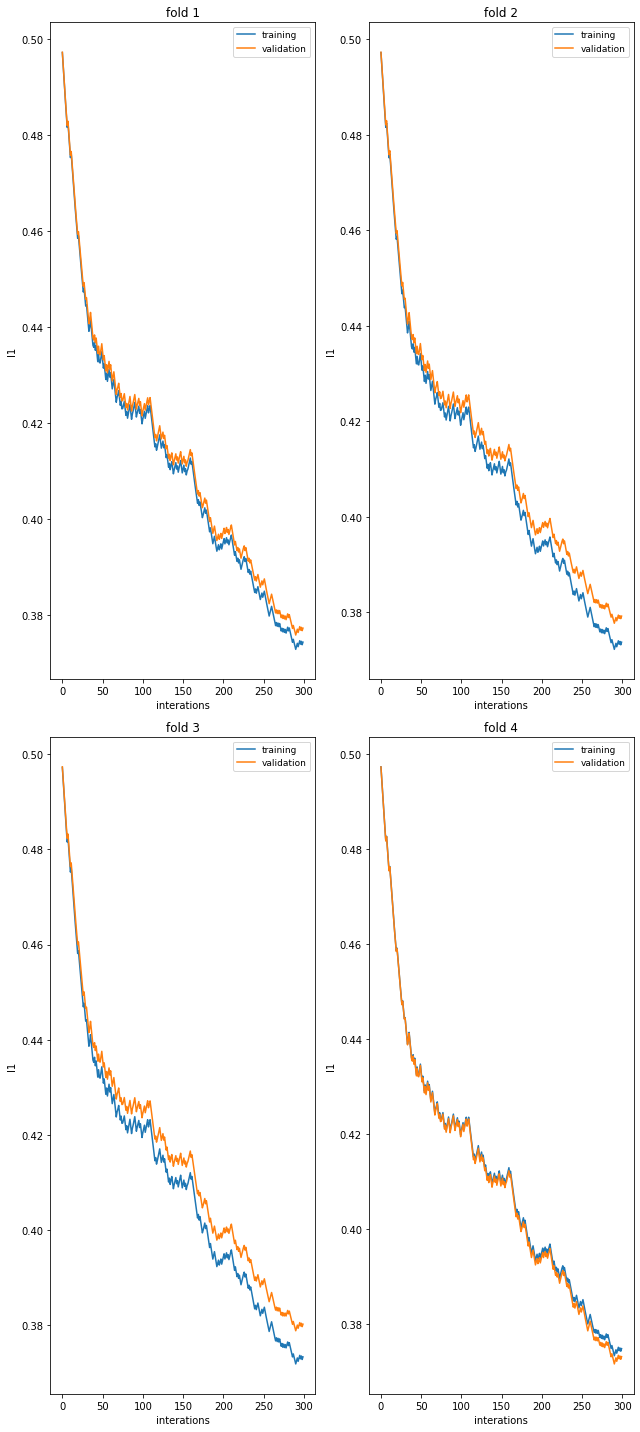

### CV scores by fold ###
fold 1: 0.3773
fold 2: 0.3792
fold 3: 0.3802
fold 4: 0.3731
CV mean score: 0.3775, std: 0.0027.
CPU times: user 5min 43s, sys: 15.5 s, total: 5min 58s
Wall time: 2min 38s


In [193]:
%%time
group_kfold = GroupKFold(n_splits=4)

feature_importance, test_pred = \
    model_training(X, y, group_kfold, s, lgb_params, 
    'l1', early_stopping=50, plt_iter=True, X_test=X_test)

Text(0.5, 1.0, 'Feature Importnace')

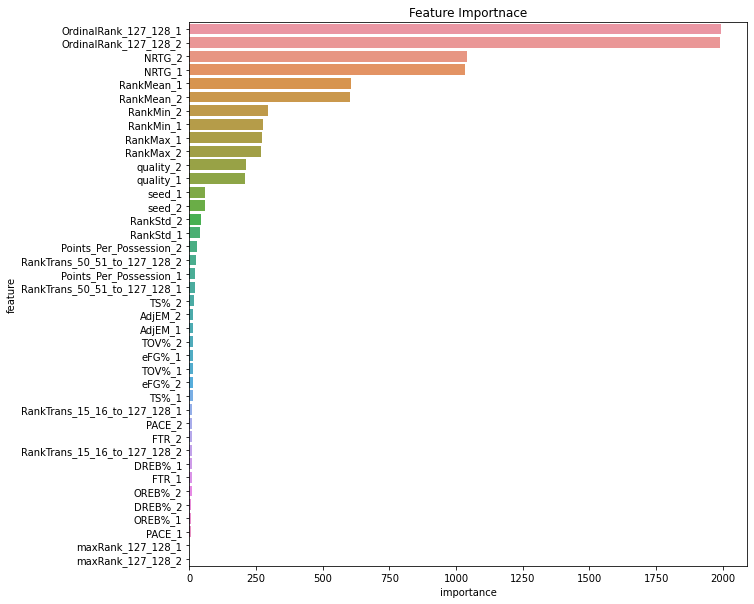

In [194]:
plt.figure(figsize=(10, 10));
sns.barplot(x="importance", y="feature", data=feature_importance)
plt.title('Feature Importnace')

In [195]:
MSampleSubmission = pd.read_csv(DIR_PATH+'/MSampleSubmissionStage2.csv')

In [196]:
idx = test_pred.shape[0] // 2
test_pred[idx:] = 1 - test_pred[idx:]

pred = pd.concat([test.ID, pd.Series(test_pred)], axis=1).groupby('ID')[0]\
        .mean().reset_index().rename(columns={0:'Pred'})
sub = MSampleSubmission.drop(['Pred'],axis=1).merge(pred, on='ID')
sub.to_csv('small_mae_score.csv', index=False)
sub.head()

,ID,Pred
0,2021_1101_1104,0.296917
1,2021_1101_1111,0.754714
2,2021_1101_1116,0.294810
3,2021_1101_1124,0.260149
4,2021_1101_1140,0.383739


<AxesSubplot:>

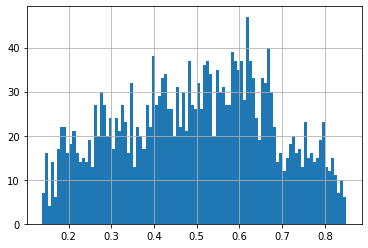

In [197]:
sub['Pred'].hist(bins=100)

In [198]:
# 2015_2021_all_maeが一番バランスが良かった
print(len(sub.loc[sub['Pred'] > 0.5, 'Pred']))
print(len(sub.loc[sub['Pred'] < 0.5, 'Pred']))

1173
1105
